# DTProblog Example

The example below uses the decision theoretic problog program to execute the umbrella example.

In [1]:
from problog.tasks.dtproblog import dtproblog
from problog.program import PrologString

In [2]:
model = """
% probabilistic facts
0.3::rain.
0.5::wind.

% decision facts
?::umbrella.
?::raincoat.

broken_umbrella :- umbrella, rain, wind.
dry :- rain, raincoat.
dry :- rain, umbrella, not broken_umbrella.
dry :- not rain.

% utilities
utility(broken_umbrella, -40).
utility(raincoat, -20).
utility(umbrella, -2).
utility(dry, 60).
"""

In [3]:
program = PrologString(model)
decisions, score, statistics = dtproblog(program)

In [4]:
for name, value in decisions.items():
    print('{}: {}'.format(name, value))

print(decisions)

umbrella: 1
raincoat: 0
{umbrella: 1, raincoat: 0}


In [5]:
print(score)

43.00000000000001


In [6]:
print(statistics)

{'eval': 4}


# Bayesian Network

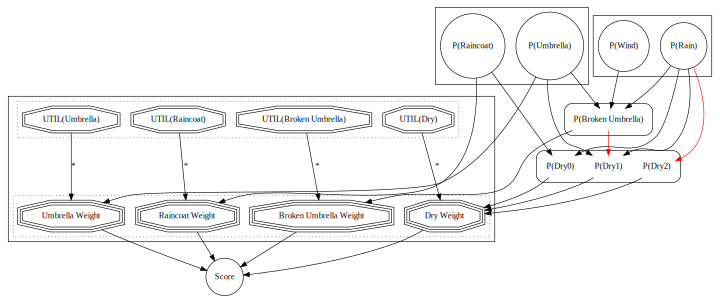

In [7]:
from graphviz import Digraph

g = Digraph('Bayesian Network', filename='fsm.gv')

g.attr(rank='same', size='10,10')
g.attr('node', shape='circle')

with g.subgraph(name='clusterA') as c:
    c.node('P(Rain)')
    c.node('P(Wind)')

with g.subgraph(name='clusterB') as c:
    c.node('P(Umbrella)')
    c.node('P(Raincoat)')

with g.subgraph(name='clusterC') as c:
    c.attr(style='rounded')
    c.attr('node', shape='none')
    c.node('P(Broken Umbrella)')

with g.subgraph(name='clusterH') as h:
    with h.subgraph(name='clusterD') as c:
        c.attr(style='dotted')
        c.attr('node', shape='tripleoctagon')
        c.node('Dry Weight')
        c.node('Broken Umbrella Weight')
        c.node('Umbrella Weight')
        c.node('Raincoat Weight')

    with h.subgraph(name='clusterE') as c:
        c.attr(style='dotted')
        c.attr('node', shape='doubleoctagon')
        c.node('UTIL(Broken Umbrella)')
        c.node('UTIL(Dry)')
        c.node('UTIL(Umbrella)')
        c.node('UTIL(Raincoat)')

with g.subgraph(name='clusterF') as c:
    c.attr(style='rounded')
    c.attr('node', shape='none')
    c.edge('P(Rain)', 'P(Dry0)')
    c.edge('P(Raincoat)', 'P(Dry0)')

    c.edge('P(Rain)', 'P(Dry1)')
    c.edge('P(Umbrella)', 'P(Dry1)')
    c.edge('P(Broken Umbrella)', 'P(Dry1)', color='red')

    c.edge('P(Rain)', 'P(Dry2)', color='red')

with g.subgraph(name='clusterG') as c:
    c.edge('P(Umbrella)', 'P(Broken Umbrella)')
    c.edge('P(Rain)', 'P(Broken Umbrella)')
    c.edge('P(Wind)', 'P(Broken Umbrella)')

g.edge('P(Dry0)', 'Dry Weight')
g.edge('P(Dry1)', 'Dry Weight')
g.edge('P(Dry2)', 'Dry Weight')
g.edge('UTIL(Dry)', 'Dry Weight', label='*')

g.edge('P(Broken Umbrella)', 'Broken Umbrella Weight')
g.edge('UTIL(Broken Umbrella)', 'Broken Umbrella Weight', label='*')

g.edge('P(Umbrella)', 'Umbrella Weight')
g.edge('UTIL(Umbrella)', 'Umbrella Weight', label='*')

g.edge('P(Raincoat)', 'Raincoat Weight')
g.edge('UTIL(Raincoat)', 'Raincoat Weight', label='*')


g.edge('Dry Weight', 'Score')
g.edge('Broken Umbrella Weight', 'Score')
g.edge('Umbrella Weight', 'Score')
g.edge('Raincoat Weight', 'Score')

g

# The Math

From code to equations + reductions using Algebra of Sets:

```
% probabilistic facts
0.3::rain.
0.5::wind.

% decision facts
?::umbrella.
?::raincoat.

broken_umbrella :- umbrella, rain, wind.
dry :- rain, raincoat.
dry :- rain, umbrella, not broken_umbrella.
dry :- not rain.

% utilities
utility(broken_umbrella, -40).
utility(raincoat, -20).
utility(umbrella, -2).
utility(dry, 60).
```

---

## DT-Problog Utilities

Taken from: <cite data-cite="post1">DTProbLog: A Decision-Theoretic Probabilistic Prolog</cite>

A single utility is defined as:

$$
\text{Util}(a_i|\sigma,\mathcal{DT}) = r_i \cdot P(u_i|\sigma(\mathcal{DT}))
$$

- $u_i$ is a literal
- $r_i$ is the reward/consequence for achieving $u_i$
- $\mathcal{DT}$ Problog program
- $\sigma$ strategy

Total Utility:

$$
\text{Util}(\sigma, \mathcal{DT}) = \sum_{a_i \in U} \text{Util}(a_i|\sigma(\mathcal{DT})) = \text{Util}(\sigma(\mathcal{DT}))
$$

When faced with a decision problem, one is interested in computing the optimal strategy, which is, the maximum expected utility principle:

$$
\sigma^* = \text{argmax}_\sigma  \text{Util}(\sigma(\mathcal{DT}))
$$

This is the *solution* to the decision problem.

---

## Equations

We are provided the following probabilistic facts about the weather:

$$
\begin{align}
P(\text{rain}) &= 0.3\\
P(\text{wind}) &= 0.5
\end{align}
$$

We decide to choose from the following options, which are shown as probabilities to fit in with the math:

$$
\begin{align}
P(\text{umbrella}) &= \text{?}\\
P(\text{raincoat}) &= \text{?}
\end{align}
$$

First, we assume that are choices are mutually exclusive, that is, only one option can be chosen. Mainly since it defeats the purpose of having both a raincoat and an umbrella (wasted resources/efficiency). This will slightly reduce the computations a bit.

Then from the code above we can form some equations:

---

```
broken_umbrella :- umbrella, rain, wind.
```

$$
\text{broken umbrella} = \text{umbrella} \cap \text{rain} \cap \text{wind}
$$

---

```
dry :- rain, raincoat.
dry :- rain, umbrella, not broken_umbrella.
dry :- not rain.
```

$$
\begin{align}
\text{dry}_0 &= \text{rain} \cap \text{raincoat} \\
\text{dry}_1 &= \text{rain} \cap \text{umbrella} \cap \overline{\text{broken umbrella}} \\
                &= \text{rain} \cap \text{umbrella} \cap \overline{\text{wind}} \\
\text{dry}_2 &= \overline{\text{rain}} \\
\text{dry} &= \text{dry}_0 \cup \text{dry}_1 \cup \text{dry}_2 \\
           &= [\text{rain} \cap \text{raincoat}] \cup [\text{rain} \cap \text{umbrella} \cap \overline{\text{wind}}] \cup [\overline{\text{rain}}]
\end{align}
$$

---

The proof of the simplification on $P(\text{dry}_1)$:

---

$$
\begin{align}
\text{dry}_1 &= \text{rain} \cap \text{umbrella} \cap \overline{\text{broken umbrella}} \\
&= \text{rain} \cap \text{umbrella} \cap [\overline{\text{umbrella} \cap \text{rain} \cap P(\text{wind})}] \\
&= [\text{rain} \cap \text{umbrella}] \cap [\overline{\text{umbrella}} \cup \overline{\text{rain}} \cup \overline{\text{wind}}] \\
&= [\text{rain} \cap \text{umbrella} \cap \overline{\text{umbrella}}] \cup [\text{rain} \cap \text{umbrella} \cap \overline{\text{rain}}] \cup [\text{rain} \cap \text{umbrella} \cap \overline{\text{wind}}] \\
&= \varnothing \cup \varnothing \cup [\text{rain} \cap \text{umbrella} \cap \overline{\text{wind}}] \\
&= \text{rain} \cap \text{umbrella} \cap \overline{\text{wind}}
\end{align}
$$

---

## Probability Rules


### Union/OR/Disjunction/v

$$
P(A \cup B) = P(A) + P(B) - P(A \cap B)
$$

If $A$ and $B$ are mutually exclusive:

$$
P(A \cup B) = P(A) + P(B)
$$

### Intersectin/AND/Conjunction/^

$$
P(A \cap B) = P(A) \cdot P(B)
$$

---

## Problog Example

Thus we can compute the probabilities of the algebraic sets:

$$
\begin{align}
P(\text{broken umbrella}) &= P(\text{umbrella} \cap \text{rain} \cap \text{wind}) \\
                          &= P(\text{umbrella}) \cdot P(\text{rain}) \cdot P(\text{wind}) \\
                          &= P(\text{umbrella}) \cdot 0.3 \cdot 0.5 \\
                          \\
P(\text{dry}) &= P(\text{dry}_0 \cup \text{dry}_1 \cup \text{dry}_2) \\
           &= P([\text{rain} \cap \text{raincoat}] \cup [\text{rain} \cap \text{umbrella} \cap \overline{\text{wind}}] \cup [\overline{\text{rain}}]) \\
           &= [P(\text{rain}) \cdot P(\text{raincoat})] + [P(\text{rain}) \cdot P(\text{umbrella}) \cdot (1 - P(\text{wind}))] + [1-P(\text{rain})]\\
           &= [0.3 \cdot P(\text{raincoat})] + [0.3 \cdot P(\text{umbrella}) \cdot 0.5] + [0.7]
\end{align}
$$

### Finding the maximum expected utility principle

Using the rewards defined:

```
utility(broken_umbrella, -40).
utility(raincoat, -20).
utility(umbrella, -2).
utility(dry, 60).
```

We can find the decision that would provide the maximum value between the two choices, bringing an umbrella or bringing a raincoat;

ie. $P(\text{umbrella}) = 1$ or $P(\text{raincoat}) = 1$

$$
\sigma^* = \text{argmax}_\sigma  \text{Util}(\sigma(\mathcal{DT}))
$$

---

$$
\begin{align}
\text{Util}(\sigma(\mathcal{DT})) &= \sum_{a_i \in U} \text{Util}(a_i|\sigma(\mathcal{DT}))\\
                                  &= \text{Util}(\text{broken umbrella}| \sigma, \mathcal{DT}) + \text{Util}(\text{raincoat}| \sigma, \mathcal{DT}) + \text{Util}(\text{umbrella}| \sigma, \mathcal{DT}) + \text{Util}(\text{dry}| \sigma, \mathcal{DT})\\
                                  &= r_\text{broken umbrella} \cdot P(\text{broken umbrella}) + r_\text{raincoat} \cdot P(\text{raincoat}) + r_\text{umbrella} \cdot P(\text{umbrella}) + r_\text{dry} \cdot P(\text{dry})\\
                                  &= -40 \cdot P(\text{broken umbrella}) + -20 \cdot P(\text{raincoat}) + -2 \cdot P(\text{umbrella}) + 60 \cdot P(\text{dry})\\
                                  &= -40 \cdot (P(\text{umbrella}) \cdot 0.3 \cdot 0.5) + -20 \cdot P(\text{raincoat}) + -2 \cdot P(\text{umbrella}) + (60 \cdot (0.3 \cdot P(\text{raincoat}) + [0.3 \cdot P(\text{umbrella}) \cdot 0.5] + 0.7))
\end{align}
$$

Then we can solve:

$$
\sigma^* = \text{argmax}_{\sigma \in \{P(\text{umbrella}) = 1, P(\text{raincoat}) = 1,\}}  \text{Util}(\sigma(\mathcal{DT}))
$$

# Python Implementation

The code below uses regular python to achieve the same result as the umbrella example shown above.

In [8]:
# compute total utility given that decisions are mutually exclusive

# define facts
pRain = 0.3
pWind = 0.5

# define utility
broken_umbrella_utility = -40
raincoat_utility = -20
umbrella_utility = -2
dry_utility = 60

def total_utility(pUmbrella, pRainCoat):
    pDry = (1-pRain) + pRain*pUmbrella*(1-pWind) + pRain*pRainCoat
    pBrokenUmbrella = pUmbrella*pRain*pWind
    
    print('Dry Weight: {}'.format(pDry * dry_utility))
    print('Broken Umbrella Weight: {}'.format(pBrokenUmbrella * broken_umbrella_utility))
    print('Umbrella Weight: {}'.format(pRainCoat * raincoat_utility))
    print('Raincoat Weight: {}'.format(pUmbrella * umbrella_utility))
    
    # compute and return the score
    return (pDry * dry_utility + 
            pBrokenUmbrella * broken_umbrella_utility + 
            pRainCoat * raincoat_utility + 
            pUmbrella * umbrella_utility)

print('-------------------------------------------')
print('Umbrella Option:')
umbrella_score = total_utility(1., 0.)
print('-------------------------------------------')


print('\n-------------------------------------------')
print('Raincoat Option:')
raincoat_score = total_utility(0., 1.)
print('-------------------------------------------\n')

print('Umbrella Score: {}'.format(umbrella_score))
print('Raincoat Score: {}'.format(raincoat_score))

-------------------------------------------
Umbrella Option:
Dry Weight: 51.0
Broken Umbrella Weight: -6.0
Umbrella Weight: -0.0
Raincoat Weight: -2.0
-------------------------------------------

-------------------------------------------
Raincoat Option:
Dry Weight: 60.0
Broken Umbrella Weight: -0.0
Umbrella Weight: -20.0
Raincoat Weight: -0.0
-------------------------------------------

Umbrella Score: 43.0
Raincoat Score: 40.0


# Nengo DTProblog Implementation

The code below uses nengo to achieve the same result as the umbrella example shown above.

Within Nengo we directly compute, using ensembles and pre-built networks, the following equations:

$$
\begin{align}
\text{Util}(\sigma(\mathcal{DT})) &= \sum_{a_i \in U} \text{Util}(a_i|\sigma(\mathcal{DT}))\\
                                  &= \text{Util}(\text{broken umbrella}| \sigma, \mathcal{DT}) + \text{Util}(\text{raincoat}| \sigma, \mathcal{DT}) + \text{Util}(\text{umbrella}| \sigma, \mathcal{DT}) + \text{Util}(\text{dry}| \sigma, \mathcal{DT})\\
                                  &= r_\text{broken umbrella} \cdot P(\text{broken umbrella}) + r_\text{raincoat} \cdot P(\text{raincoat}) + r_\text{umbrella} \cdot P(\text{umbrella}) + r_\text{dry} \cdot P(\text{dry})
\end{align}
$$

The pre-build networks of the Basal Ganglia and Thalamus can be used to compute the equation which operate as a WTA and a selector:

$$
\sigma^* = \text{argmax}_{\sigma \in \{P(\text{umbrella}) = 1, P(\text{raincoat}) = 1,\}}  \text{Util}(\sigma(\mathcal{DT}))
$$

The main pre-built networks used are:

- `nengo.networks.Product()`
- `nengo.networks.BasalGanglia()`
- `nengo.networks.Thalamus()`

The dimensions of the BasalGanglia and the Thalamus are 2, essentially one dimension per decision. The first dimension is the choice of `Umbrella` and the second is `Raincoat`. Ensembles are used to hold the probability for intermediate calculations, which store a value between 0 and 1 (thus we can define the radius).

Scaling is performed on the rewards such that the rewards are between 0 and 1 to fit within the ensemble radius. This allows for compression of the ensemble's dynamic range.

Sizes of the ensembles (`n_neurons`) are chosen arbitary large enough to avoid error. This can be reduced for efficiency.

## Decision Changes

From the equations shown above, note that we can observe a decision change by manipulating the equations. Here we can see that `Umbrella` is chosen initially as it has a score of 43 which is greater than the score of when we chose `Raincoat` which is 40.

We can manipulate the equations such that we can choose `Raincoat`. One way of doing this is modifying the reward/cost of choosing `Raincoat` from -20 to -16. As a result, the score from choosing `Umbrella` would remain 43, but the score from choosing `Raincoat` would be 44, causing `Raincoat` to be chosen.

Implementing this to partly verify that Nengo is working as expected, we adjust the cost of `Raincoat` as time progresses by making it a function of time.

```python
def raincoat_cost(t):
    return -20. + 4. * t
```

By adding this adjustment, we should observe a change in decision as time progresses. More specifically, around $t=1$, the decision should change.

In [11]:
import nengo

def raincoat_cost(t):
    return -20. + 4.*(t%5.)
    #return -20. + 4.*t

rain = 0.3
wind = 0.5
model = nengo.Network('Umbrella Example', seed=8)

n_neurons = 1000
with model:
    # define facts
    rain_fact = nengo.Node([rain])
    wind_fact = nengo.Node([wind])
    
    # define rewards
    broken_umbrella_util = nengo.Node([-40])
    #raincoat_util = nengo.Node([-20])
    raincoat_util = nengo.Node(raincoat_cost)
    umbrella_util = nengo.Node([-2])
    dry_util = nengo.Node([60])
    
    # world set (for NOT calculations)
    S = nengo.Node([1])
    
    # terms for computing total utility and constructing bayesian network
    pDry = nengo.Ensemble(n_neurons, 2)
    pRain = nengo.Ensemble(n_neurons, 1)
    pWind = nengo.Ensemble(n_neurons, 1)
    pUmbrella = nengo.Ensemble(n_neurons, 2)
    pRainCoat = nengo.Ensemble(n_neurons, 2)
    pBrokenUmbrella = nengo.Ensemble(n_neurons, 1)
    
    # define umbrella and raincoat
    umbrella = nengo.Node([1, 0])
    raincoat = nengo.Node([0, 1])
    nengo.Connection(umbrella, pUmbrella)
    nengo.Connection(raincoat, pRainCoat)
    
    # construct pRain
    nengo.Connection(rain_fact, pRain)
    
    # construct pWind
    nengo.Connection(wind_fact, pWind)
    
    # construct pDry, size 2 (umbrella, raincoat)
    # (1-pRain)
    nengo.Connection(S, pDry, transform=[[1], [1]])
    nengo.Connection(pRain, pDry, transform=[[-1], [-1]])
    
    # pRain*pUmbrella
    dry_term_1 = nengo.networks.Product(n_neurons, 1, label='dry_term_1')
    nengo.Connection(pRain, dry_term_1.input_a)
    nengo.Connection(pUmbrella[0], dry_term_1.input_b)
    
    # pRain*pUmbrella*(1-pWind)
    dry_term_2 = nengo.networks.Product(n_neurons, 1, label='dry_term_2')
    nengo.Connection(dry_term_1.output, dry_term_2.input_a)
    nengo.Connection(S, dry_term_2.input_b)
    nengo.Connection(pWind, dry_term_2.input_b, transform=-1)
    nengo.Connection(dry_term_2.output, pDry[0])
    
    # pRain*pRainCoat
    dry_term_3 = nengo.networks.Product(n_neurons, 1, label='dry_term_3')
    nengo.Connection(pRain, dry_term_3.input_a)
    nengo.Connection(pRainCoat[1], dry_term_3.input_b)
    nengo.Connection(dry_term_3.output, pDry[1])
    
    # construct pBrokenUmbrella, size 1
    #pUmbrella*pRain*pWind
    brokenUmbrella_term_1 = nengo.networks.Product(n_neurons, 1, label='brokenUmbrella_term_1')
    nengo.Connection(pRain, brokenUmbrella_term_1.input_a)
    nengo.Connection(pUmbrella[0], brokenUmbrella_term_1.input_b)
    
    brokenUmbrella_term_2 = nengo.networks.Product(n_neurons, 1, label='brokenUmbrella_term_2')
    nengo.Connection(brokenUmbrella_term_1.output, brokenUmbrella_term_2.input_a)
    nengo.Connection(pWind, brokenUmbrella_term_2.input_b)
    nengo.Connection(brokenUmbrella_term_2.output, pBrokenUmbrella)
    
    # compute weighted propability
    #(pDry * dry_utility + 
    #        pBrokenUmbrella * broken_umbrella_utility + 
    #        pRainCoat * raincoat_utility + 
    #        pUmbrella * umbrella_utility)
    
    # since all util values are ranged from 0-60, scale by a factor for all utility values
    # this should all the values across the board such while allowing us to keep the radius between [-1,1]
    util_transform = [[.01], [.01]]
    
    dry_weight = nengo.networks.Product(n_neurons, 2, input_magnitude=1, label='dry_weight')
    nengo.Connection(pDry, dry_weight.input_a)
    nengo.Connection(dry_util, dry_weight.input_b, transform=util_transform)
    
    brokenUmbrella_weight = nengo.networks.Product(n_neurons, 2, input_magnitude=1, label='brokenUmbrella_weight')
    nengo.Connection(pBrokenUmbrella[0], brokenUmbrella_weight.input_a[0])
    nengo.Connection(broken_umbrella_util, brokenUmbrella_weight.input_b, transform=util_transform)
    
    raincoat_weight = nengo.networks.Product(n_neurons, 2, input_magnitude=1, label='raincoat_weight')
    nengo.Connection(pRainCoat, raincoat_weight.input_a)
    nengo.Connection(raincoat_util, raincoat_weight.input_b, transform=util_transform)
    
    umbrella_weight = nengo.networks.Product(n_neurons, 2, input_magnitude=1, label='umbrella_weight')
    nengo.Connection(pUmbrella, umbrella_weight.input_a)
    nengo.Connection(umbrella_util, umbrella_weight.input_b, transform=util_transform)
    
    BG = nengo.networks.BasalGanglia(dimensions=2) # 2 choices
    nengo.Connection(dry_weight.output, BG.input)
    nengo.Connection(brokenUmbrella_weight.output, BG.input)
    nengo.Connection(raincoat_weight.output, BG.input)
    nengo.Connection(umbrella_weight.output, BG.input)
    
    TH = nengo.networks.Thalamus(dimensions=2)
    nengo.Connection(BG.output, TH.input)
    
    # define some probes
    # probe weights
    p_dry_weight = nengo.Probe(dry_weight.output)
    p_brokenUmbrella_weight = nengo.Probe(brokenUmbrella_weight.output)
    p_raincoat_weight = nengo.Probe(raincoat_weight.output)
    p_umbrella_weight = nengo.Probe(umbrella_weight.output)
    
    # probe BG/TH
    p_BG_in = nengo.Probe(BG.input)
    p_TH_in = nengo.Probe(TH.input)
    p_BG_out = nengo.Probe(BG.output)
    p_TH_out = nengo.Probe(TH.output)

print('Model uses {} neurons'.format(model.n_neurons))

Model uses 20100 neurons


In [12]:
# View Model
from nengo_gui.ipython import IPythonViz
IPythonViz(model)

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['figure.subplot.top'] = 1
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14

#plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_dry_weight], '*')
plt.plot(sim.trange(), sim.data[p_brokenUmbrella_weight], '*')
plt.plot(sim.trange(), sim.data[p_raincoat_weight], '*')
plt.plot(sim.trange(), sim.data[p_umbrella_weight], '*')
plt.legend(('Dry', 'Broken Umbrella', 'Raincoat', 'Umbrella'), loc='best')
plt.title('Weighted Utilities')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_BG_in], '*')
plt.legend(('BG_in_0', 'BG_in_1',), loc='best')
plt.title('BG Input')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_BG_out], '*')
plt.legend(('BG_out_0', 'BG_out_1',), loc='best')
plt.title('BG Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_TH_out], '*')
plt.legend(('Umbrella', 'Rain Coat',), loc='best')
plt.title('TH Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

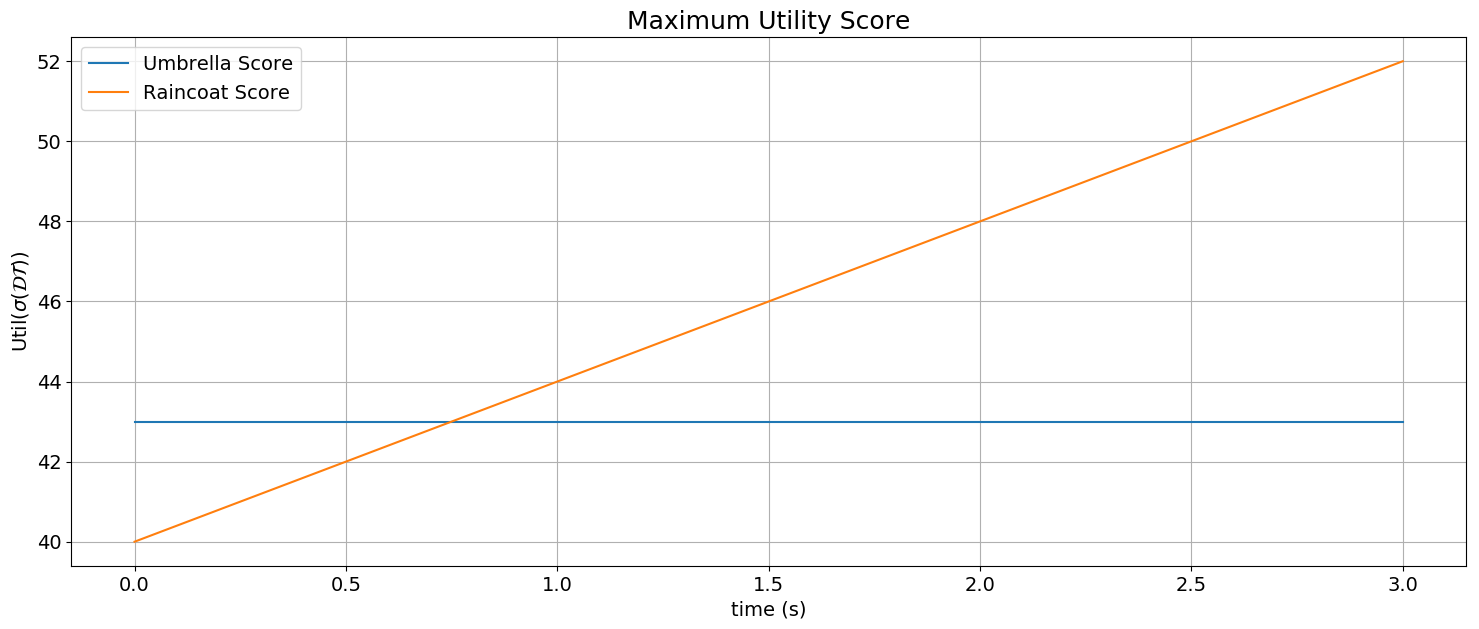

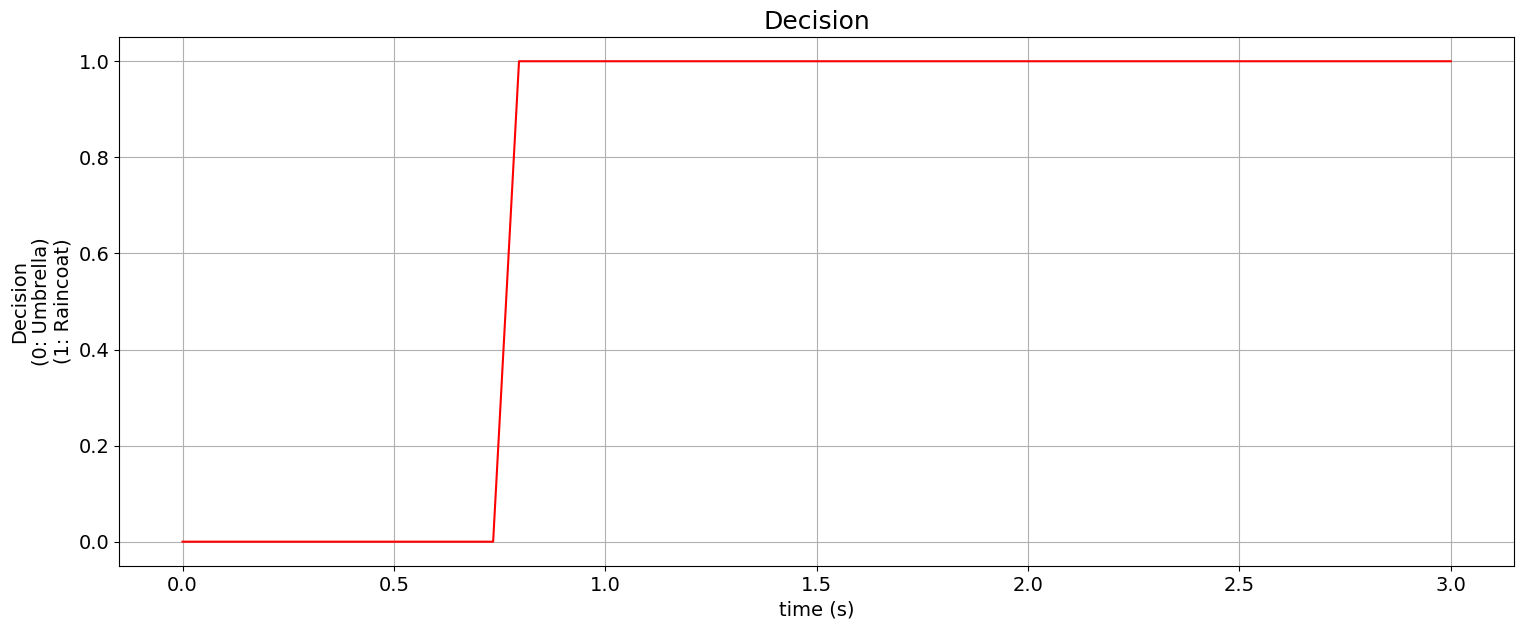

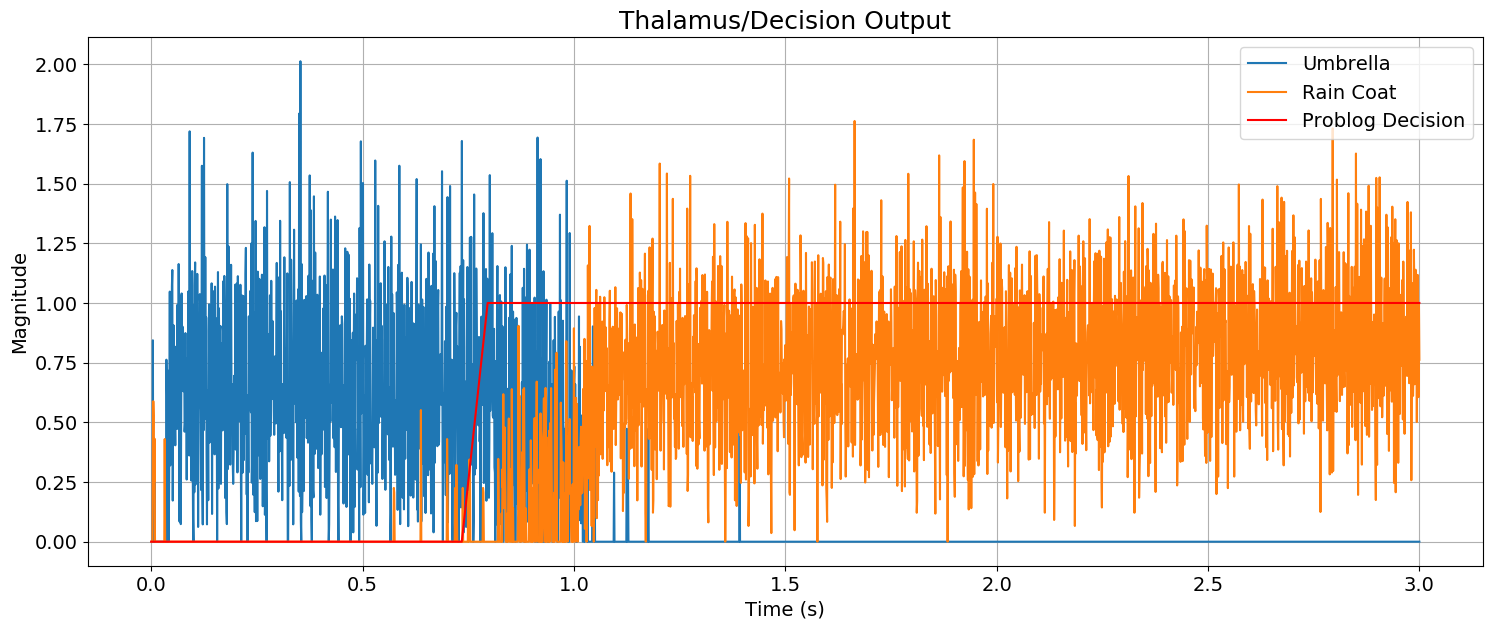

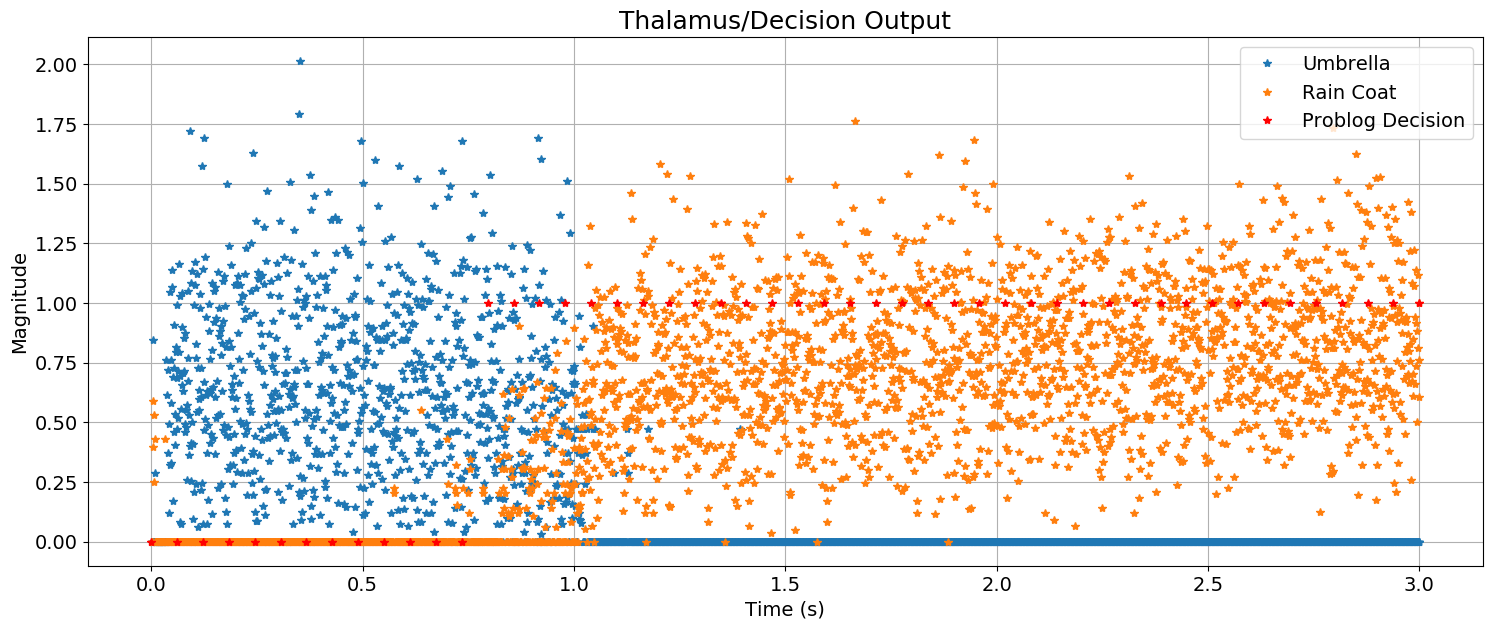

In [16]:
# redefine the score computation with parameterized utilities
import numpy as np

# compute total utility given that decisions are mutually exclusive
def total_utility(pUmbrella, pRainCoat,

    # define facts
    pRain = 0.3,
    pWind = 0.5,

    # define utility
    broken_umbrella_utility = -40,
    raincoat_utility = -20,
    umbrella_utility = -2,
    dry_utility = 60):

    pDry = (1-pRain) + pRain*pUmbrella*(1-pWind) + pRain*pRainCoat
    pBrokenUmbrella = pUmbrella*pRain*pWind
    
    #print('Dry Weight: {}'.format(pDry * dry_utility))
    #print('Broken Umbrella Weight: {}'.format(pBrokenUmbrella * broken_umbrella_utility))
    #print('Umbrella Weight: {}'.format(pRainCoat * raincoat_utility))
    #print('Raincoat Weight: {}'.format(pUmbrella * umbrella_utility))
    
    # compute and return the score
    return (pDry * dry_utility + 
            pBrokenUmbrella * broken_umbrella_utility + 
            pRainCoat * raincoat_utility + 
            pUmbrella * umbrella_utility)

# sample time
t = np.linspace(0, 3)

#print('-------------------------------------------')
#print('Umbrella Scores Over Time:')
umbrella_score = np.squeeze([total_utility(1., 0., raincoat_utility=rc_util) for rc_util in [-20 + 4*t]])
#print(umbrella_score)
#print('-------------------------------------------')


#print('\n-------------------------------------------')
#print('Raincoat Scores Over Time:')
raincoat_score = np.squeeze([total_utility(0., 1., raincoat_utility=rc_util) for rc_util in [-20 + 4*t]])
#print(raincoat_score)
#print('-------------------------------------------\n')

# compute maximum expected utility principle, set umbrella at index 0, raincoat at index 1
decision = np.argmax((umbrella_score, raincoat_score), axis=0)


# plot
plt.rcParams['figure.figsize'] = [18, 7]
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['figure.subplot.top'] = 1
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14

plt.figure()
plt.plot(t, umbrella_score)
plt.plot(t, raincoat_score)
plt.legend(['Umbrella Score', 'Raincoat Score'])
plt.ylabel('Util$(\sigma(\mathcal{DT}))$')
plt.xlabel('time (s)')
plt.title('Maximum Utility Score')
plt.grid()

plt.figure()
plt.plot(t, decision, 'r-')
plt.xlabel('time (s)')
plt.ylabel('Decision\n(0: Umbrella)\n(1: Raincoat)')
plt.title('Decision')
plt.grid()

plt.figure()
plt.plot(sim.trange(), sim.data[p_TH_out])
plt.plot(t, decision, 'r-')
plt.legend(('Umbrella', 'Rain Coat', 'Problog Decision'), loc='best')
plt.title('Thalamus/Decision Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

# plot the same thing as before but as discrete points
plt.figure()
plt.plot(sim.trange(), sim.data[p_TH_out], '*')
plt.plot(t, decision, 'r*')
plt.legend(('Umbrella', 'Rain Coat', 'Problog Decision'), loc='best')
plt.title('Thalamus/Decision Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.grid()

In [24]:
import nengo_loihi as loihi
loihi.set_defaults()
with loihi.Simulator(model) as sim:
    sim.run(3)

/home/turtlebot/.virtualenvs/turtlebot_py3/lib/python3.6/site-packages/nengo_loihi/builder/ensemble.py:35: UserWarning: Intercepts are larger than intercept limit (0.95). High intercept values cause issues when discretizing the model for running on Loihi.
  "the model for running on Loihi." % intercept_limit)
/home/turtlebot/.virtualenvs/turtlebot_py3/lib/python3.6/site-packages/nengo_loihi/discretize.py:396: UserWarning: Lost 1 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))
/home/turtlebot/.virtualenvs/turtlebot_py3/lib/python3.6/site-packages/nengo_loihi/discretize.py:396: UserWarning: Lost 2 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


Text(0, 0.5, 'Magnitude')

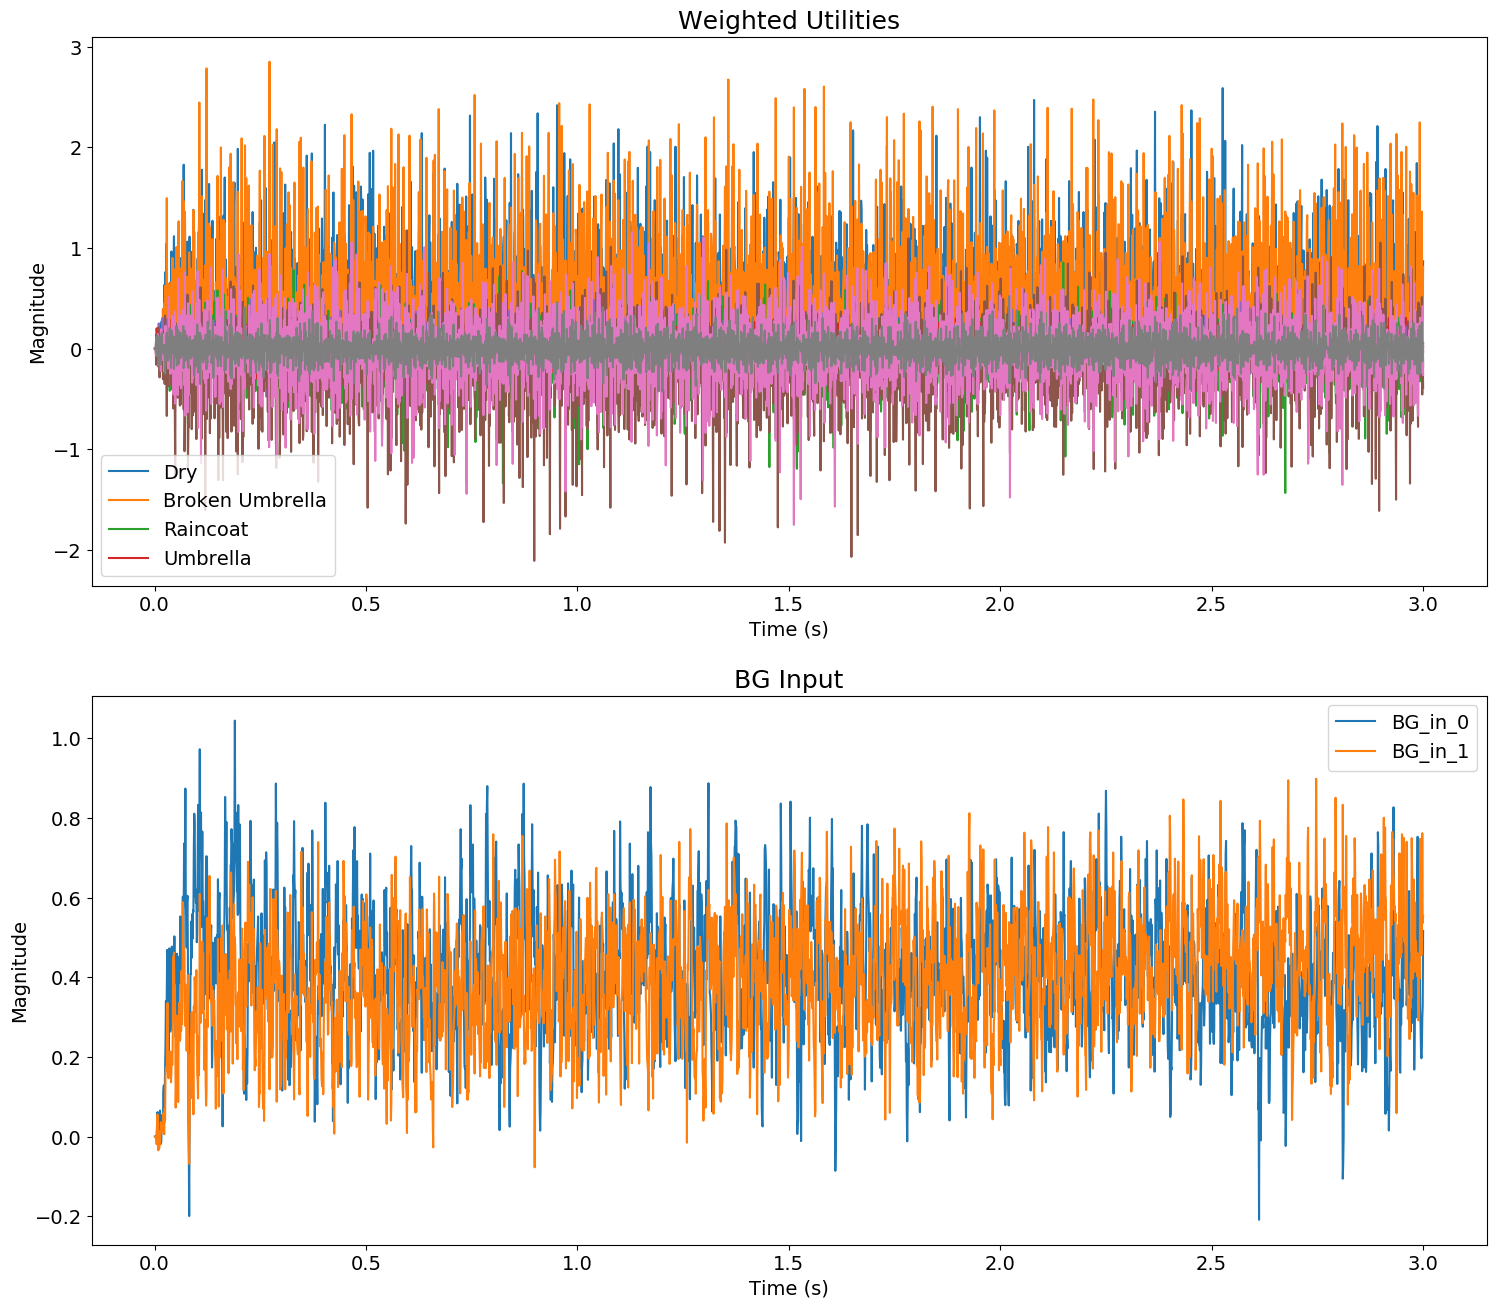

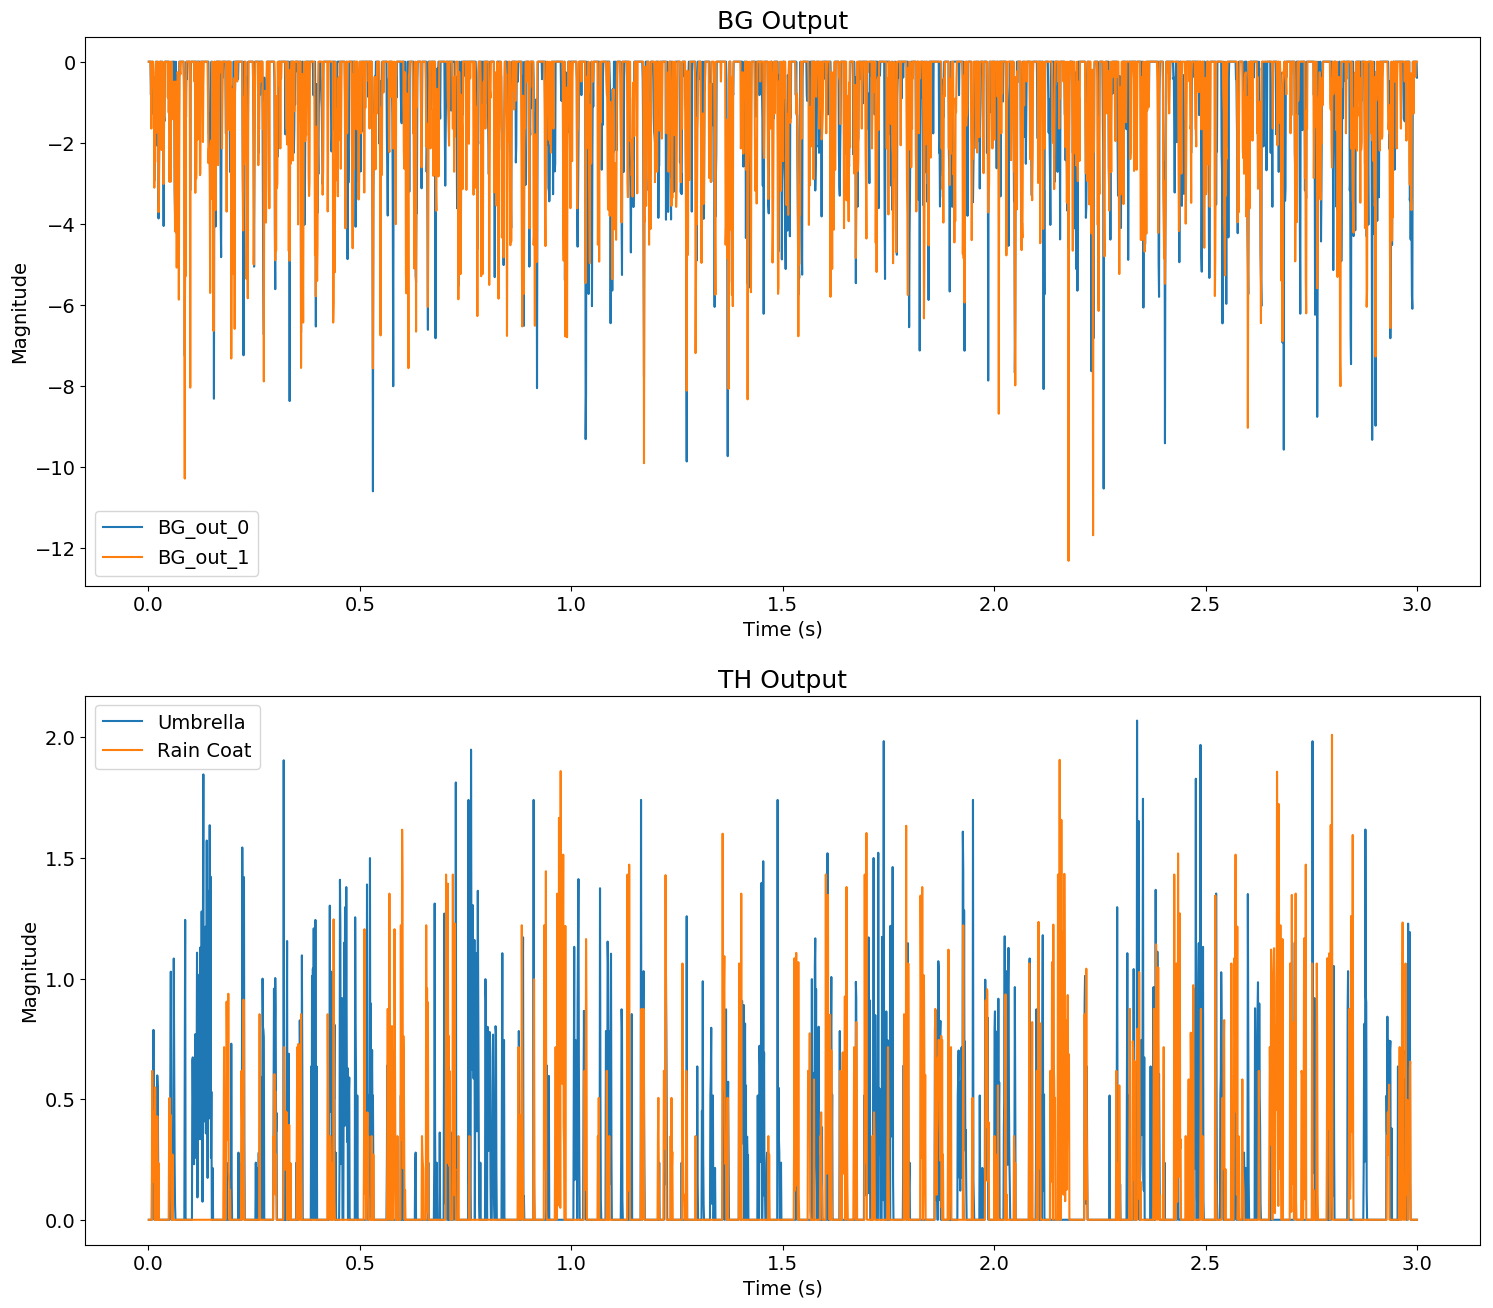

In [25]:
plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['figure.subplot.top'] = 1
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_dry_weight])
plt.plot(sim.trange(), sim.data[p_brokenUmbrella_weight])
plt.plot(sim.trange(), sim.data[p_raincoat_weight])
plt.plot(sim.trange(), sim.data[p_umbrella_weight])
plt.legend(('Dry', 'Broken Umbrella', 'Raincoat', 'Umbrella'), loc='best')
plt.title('Weighted Utilities')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_BG_in])
plt.legend(('BG_in_0', 'BG_in_1',), loc='best')
plt.title('BG Input')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_BG_out])
plt.legend(('BG_out_0', 'BG_out_1',), loc='best')
plt.title('BG Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_TH_out])
plt.legend(('Umbrella', 'Rain Coat',), loc='best')
plt.title('TH Output')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')